In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from src.src import *
from numba import jit
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:


def get_im2col_indices_conv2d_max(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)


# In[46]:


def conv2d_max(f,g,k=1,**kwargs):
    #f = f[:,np.newaxis,:,:]
    #f = np.repeat(f,3,axis=1)

    N,H,W=f.shape

    n = np.tile(np.arange(3),N-2) + np.repeat(np.arange(N-2),3)
    f = f[n,:,:].reshape((N-2,3,H,W))

    N,C,H,W = f.shape
    h,w = g

    x_pad = int(0.5*((W-1)*1-W+w))
    y_pad = int(0.5*((H-1)*1-H+w))

    f_pad = np.pad(f,((0,0),(0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='maximum')

    k,i,j = get_im2col_indices_conv2d_max((N,C,H,W), h, w, p_x=x_pad,p_y=y_pad, stride=1)

    cols = f_pad[:,k,i,j]

    xc = int((h*w-1)/2)
    cols = np.delete(cols,(xc,xc+h*w,xc+2*h*w),1)

    cond = ((f[:,1,:,:].flatten() >
             np.max(cols,axis=1).flatten())|(f[:,1,:,:].flatten() <
                                   np.min(cols,axis=1).flatten()))&(np.abs(f[:,1,:,:].flatten())>0.03)

    return np.moveaxis(cond.reshape(N,H,W),0,2)

In [4]:
@jit
def Reduce_stack(stack,k):

    N,H,W = stack.shape

    i = np.repeat(np.arange(0,H,2**k)[np.newaxis,:],W//(2**k),axis=0)
    j = np.repeat(np.arange(0,W,2**k)[:,np.newaxis],H//(2**k),axis=1)

    return np.moveaxis(stack[:,i,j],2,1)

In [10]:
def filter_stack(sig0,s,h,w):
    k = 2**(1/s)
    sigma = np.power(k,np.arange(s+1))*sig0
    g = []
    for std in sigma:
        g.append(GaussianFilter(h,w,std))
    return np.stack(g),sigma

In [44]:

def get_im2col_indices_blur(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)


def conv_octave(im,g,stride=1,C=3):
    im = im[:,np.newaxis,:,:]
    N,_,H,W = im.shape
    _,h,w = g.shape
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)

    k,i,j = get_im2col_indices_blur((N,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)

    im_padded = np.pad(im,((0,0),(0,0),(h_pad,h_pad),(w_pad,w_pad)),'mean')
    cols = im_padded[:,k,i,j]
    

    g = g.reshape((N,-1))

    
    sol = np.squeeze(np.matmul(g[:,np.newaxis,:],cols))
    
    return sol.reshape(N,H,W)


def octave(im_stack,factor,sig0=1.6,s=5,h=3,w=3):
    g,sigma = filter_stack(sig0,s,h,w)
    s1 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    s2 = np.repeat(s1.T[np.newaxis,:,:],s+1,axis=0)
    s1 = np.repeat(s1[np.newaxis,:,:],s+1,axis=0)
    
    L = conv_octave(Reduce_stack(im_stack,factor),g)
    print('Reduced shape: {}'.format(L.shape))
    
    D = L[1:s+1] - L[0:s]
    
    #D = np.clip(np.abs(D),0.03,None)
    L_gradx = conv_octave(L,s1)
    L_grady = conv_octave(L,s2)

    return D,L,sigma,(L_gradx,L_grady)

Reduced shape: (6, 156, 323)


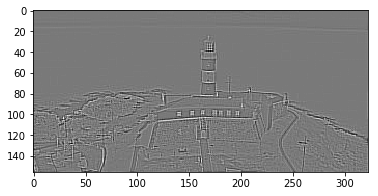

In [94]:
im = plt.imread('img/farol2.jpeg')
sig=3
s=5
factor=0
im = np.mean(im,axis=2)
im_stack = np.repeat(im[np.newaxis,:,:],s+1,axis=0)
D,L,sigma,L_grad = octave(im_stack,factor,sig0=sig,s=s)
plt.imshow(np.mean(D,axis=0),**{'cmap':'gray'})

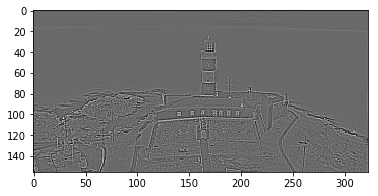

In [95]:
g=np.array([[1,1,1],[1,-8,1],[1,1,1]])
im2 = conv_octave(Reduce_stack(im_stack,0),np.repeat(g[np.newaxis,:,:],s+1,axis=0))
plt.imshow(im2[2],**{'cmap':'gray'})

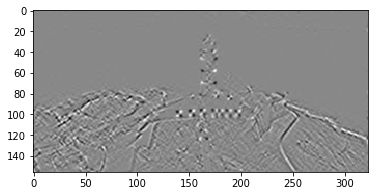

In [101]:
g=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
im2 = conv_octave(Reduce_stack(im_stack,0),np.repeat(g[np.newaxis,:,:],s+1,axis=0))
im2 = conv_octave(Reduce_stack(im2,0),np.repeat(g.T[np.newaxis,:,:],s+1,axis=0))
plt.imshow(np.max(im2,axis=0),**{'cmap':'gray'})

In [103]:
def laplacian(t,w,sigma):
    return (1/(math.pi*sigma**4))*(1-(t**2+w**2)/(2*sigma**2))*math.e**(-1*(t**2+w**2)/(2*sigma**2))
    
def Lap(w,h,sigma,grad_type='x'):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            if grad_type=='y':
                G.append(laplacian((i-n),(j-n),sigma))
            elif grad_type=='x':
                G.append(laplacian((j-n),(i-n),sigma))
    
    return np.array(G).reshape(w,h)/np.sum(np.array(G))

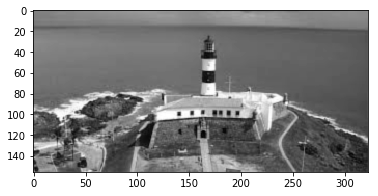

In [104]:
g=Lap(3,3,1)
im2 = conv_octave(Reduce_stack(im_stack,0),np.repeat(g[np.newaxis,:,:],s+1,axis=0))
plt.imshow(np.max(im2,axis=0),**{'cmap':'gray'})